### PREPARE DATASET, LIBRARY, AND PARAMETERS

In [46]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import os

%matplotlib inline

In [47]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.10.0-rc3
Num GPUs Available:  1


In [48]:
DATASET_DIR = "dataset/"
TEST_DIR = "test_predict/"
BATCH_SIZE = 18
IMG_HEIGHT = 224
IMG_WIDTH = 224
SHUFFLE_VALUE = True
AUTOTUNE = tf.data.experimental.AUTOTUNE

### LOAD AND SPLIT DATASET

In [49]:
# Make Train Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Make Test Dataset
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

# Print Dataset Information
print(f'Number of training batches: {len(np.concatenate([i for x, i in train_ds]))}')
print(f'Number of validation batches: {len(np.concatenate([i for x, i in val_ds]))}')
print(f'Number of test batches: {len(np.concatenate([i for x, i in test_ds]))}')

Found 550 files belonging to 3 classes.
Using 440 files for training.
Found 550 files belonging to 3 classes.
Using 110 files for validation.
Number of training batches: 440
Number of validation batches: 56
Number of test batches: 54


['mild', 'normal', 'severe']


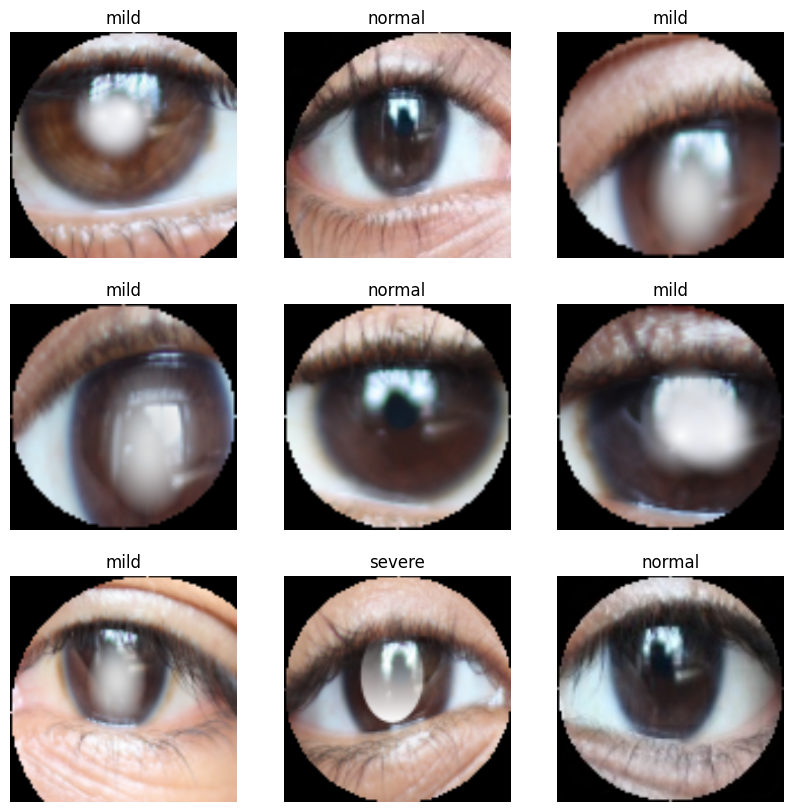

In [50]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### DATA AUGMENTATION & PIPELINING

In [51]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal'),
    keras.layers.RandomRotation(factor=0.4),
    keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
])

In [52]:
train_ds = train_ds.cache().shuffle(len(np.concatenate([i for x, i in train_ds]))).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### CALLBACK

In [53]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.95):
            print("\nReached choosen val_accuracy so cancelling training!")
            self.model.stop_training = True

### MODEL

In [54]:
base_model = keras.applications.InceptionV3(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

In [55]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  311


In [56]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_294 (Conv2D)            (None, 111, 111, 32  864         ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 111, 111, 32  96         ['conv2d_294[0][0]']             
 Normalization)                 )                                                      

In [57]:
layer_tune = 150

for layer in base_model.layers[:layer_tune]:
    layer.trainable = False

In [58]:
model = tf.keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    data_augmentation,
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(class_names))
])

In [59]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 51200)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               6553728   
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 3)                 387       
                                                                 
Total params: 28,356,899
Trainable params: 23,921,091

In [60]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [61]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[myCallback()]
)

Epoch 1/50
25/25 [==============================] - 23s 533ms/step - loss: 4.4729 - accuracy: 0.4523 - val_loss: 3654.3926 - val_accuracy: 0.2679
Epoch 2/50
25/25 [==============================] - 13s 513ms/step - loss: 0.9649 - accuracy: 0.6636 - val_loss: 208.2857 - val_accuracy: 0.2857
Epoch 3/50
25/25 [==============================] - 14s 553ms/step - loss: 0.5042 - accuracy: 0.8386 - val_loss: 534.3788 - val_accuracy: 0.2679
Epoch 4/50
25/25 [==============================] - 14s 551ms/step - loss: 0.3228 - accuracy: 0.9091 - val_loss: 330.6866 - val_accuracy: 0.2679
Epoch 5/50
25/25 [==============================] - 13s 516ms/step - loss: 0.4331 - accuracy: 0.8977 - val_loss: 985.4297 - val_accuracy: 0.2679
Epoch 6/50
25/25 [==============================] - 13s 522ms/step - loss: 0.4048 - accuracy: 0.8818 - val_loss: 12.7030 - val_accuracy: 0.3929
Epoch 7/50
25/25 [==============================] - 13s 509ms/step - loss: 0.2905 - accuracy: 0.9250 - val_loss: 3.9216 - val_accu

### EVALUATE MODEL

In [62]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

3/3 [==============================] - 0s 104ms/step - loss: 0.3197 - accuracy: 0.9815
Accuracy 0.9814814925193787


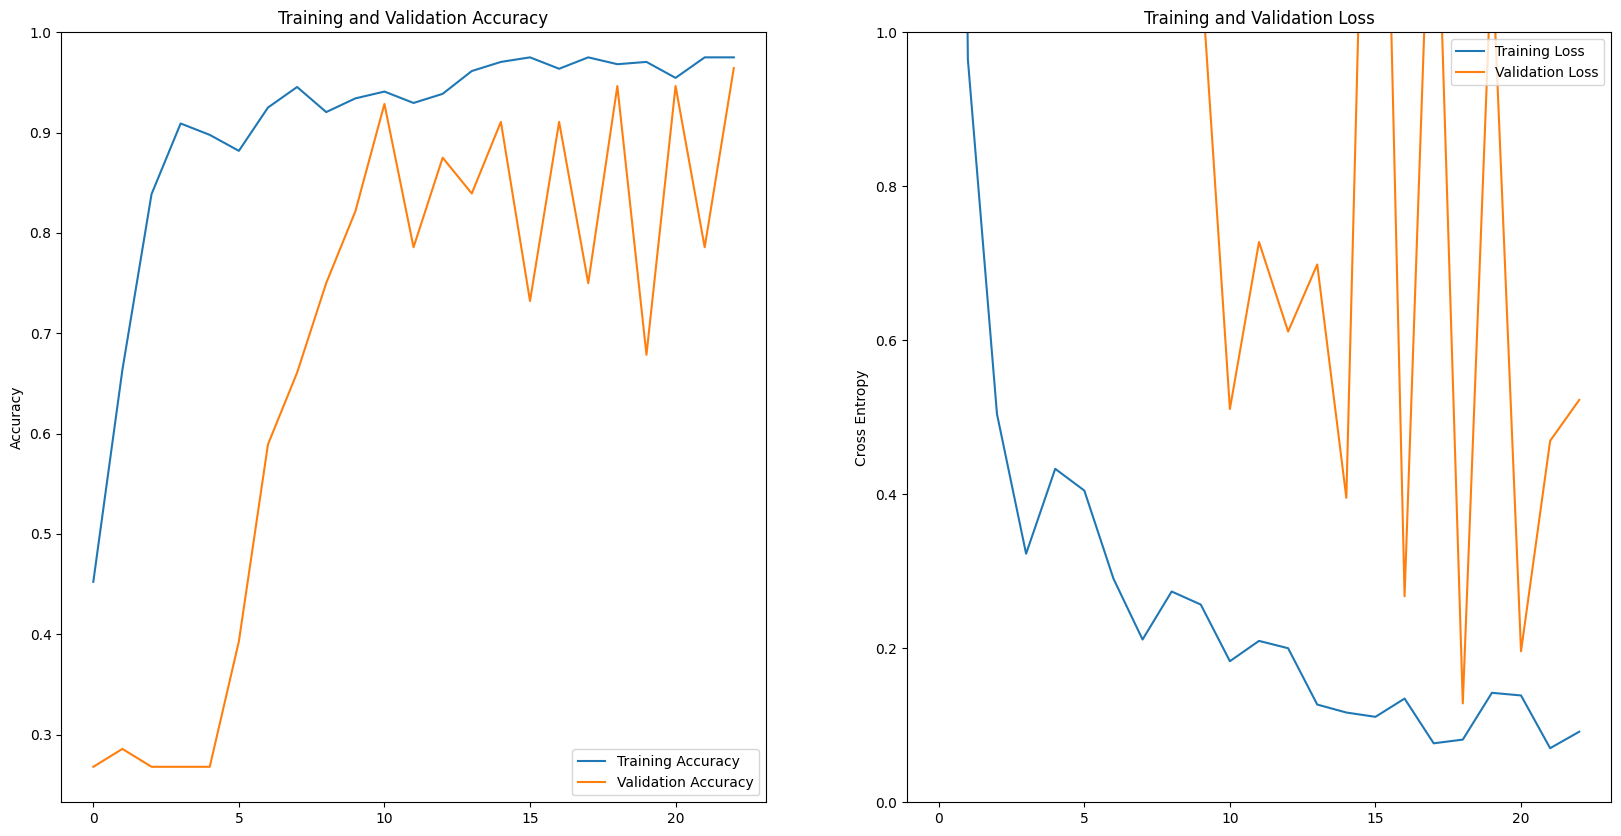

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.show()

In [64]:
y_true = np.concatenate([i for x, i in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=-1)

conf_mat = confusion_matrix(y_true, y_pred)

3/3 [==============================] - 2s 96ms/step


In [65]:
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

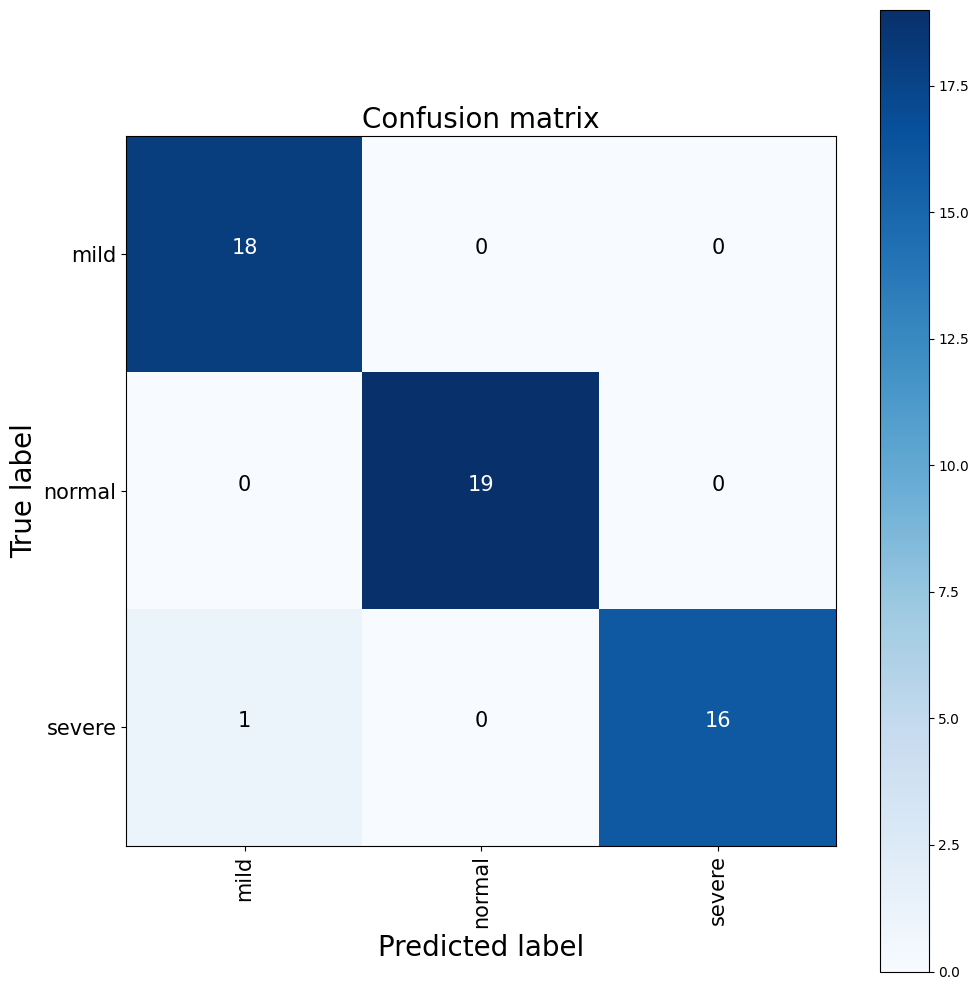

In [66]:
show_confusion_matrix(conf_mat, class_names)

### PREDICT

In [67]:
predict_model = keras.Sequential([
    model,
    keras.layers.Softmax()
])

In [68]:
for filename in os.listdir(TEST_DIR):
    img = keras.preprocessing.image.load_img(TEST_DIR + filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = predict_model.predict(img_array)
    
    score = tf.nn.softmax(predictions[0])
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(predictions)

1/1 [==============================] - 3s 3s/step
This image most likely belongs to mild with a 57.35 percent confidence.
[[9.9280143e-01 1.6454858e-04 7.0340293e-03]]
1/1 [==============================] - 0s 38ms/step
This image most likely belongs to mild with a 36.69 percent confidence.
[[0.4335382  0.21064682 0.35581493]]
1/1 [==============================] - 0s 41ms/step
This image most likely belongs to normal with a 44.26 percent confidence.
[[0.22603598 0.6424305  0.13153355]]
